In [2]:
# Useful imports
import matplotlib.pylab as plt
import numpy as np
import os
import sys
import pandas as pd

Building off of [tdr_10ftrg58cu.ipynb](tdr_10ftrg58cu.ipynb).  First attempt to extract parameters of a cryo twisted pair.

Took the following datasets:

| Data file | Termination |
| --- | --- |
| [ucryo_magnanin_twp_floatingshield_try1_20230609_direct.csv](data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_direct.csv) | direct 50 Ohm termination at scope input |
| [ucryo_magnanin_twp_floatingshield_try1_20230609_open.csv](data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_open.csv) | 4ft long ucryo shielded maganin twisted pair, floating shield, open at end furthest from oscilloscope |
| [ucryo_magnanin_twp_floatingshield_try1_20230609_shorted.csv](data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_shorted.csv) | 4ft long ucryo shielded maganin twisted pair, floating shield, shorted at end furthest from oscilloscope |
| [ucryo_magnanin_twp_floatingshield_try1_20230609_125Ohm.csv](data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_125Ohm.csv) | 4ft long ucryo shielded maganin twisted pair, floating shield, terminated into 125 Ohm |
| [ucryo_magnanin_twp_floatingshield_try1_20230609_62pt5Ohm.csv](data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_62pt5Ohm.csv) | 4ft long ucryo shielded maganin twisted pair, floating shield, terminated into 62.5 Ohm |
| [ucryo_magnanin_twp_floatingshield_try1_20230609_250pt2Ohm.csv](data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_250pt2Ohm.csv) | 4ft long ucryo shielded maganin twisted pair, floating shield, terminated into 250.2 Ohm |
| [ucryo_magnanin_twp_floatingshield_try1_20230609_499Ohm.csv](data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_499Ohm.csv) | 4ft long ucryo shielded maganin twisted pair, floating shield, terminated into 499 Ohm |

Manganin twisted pair is very resistive.  The round trip DC resistance of this 4ft length is 88.8 Ohm, so 22 Ohm/ft.

We'll use the SPICE PWL source to generate the measured function generator pulse.  First generate a PWL file from the dataset with the 50 Ohm termination instead of the cable.

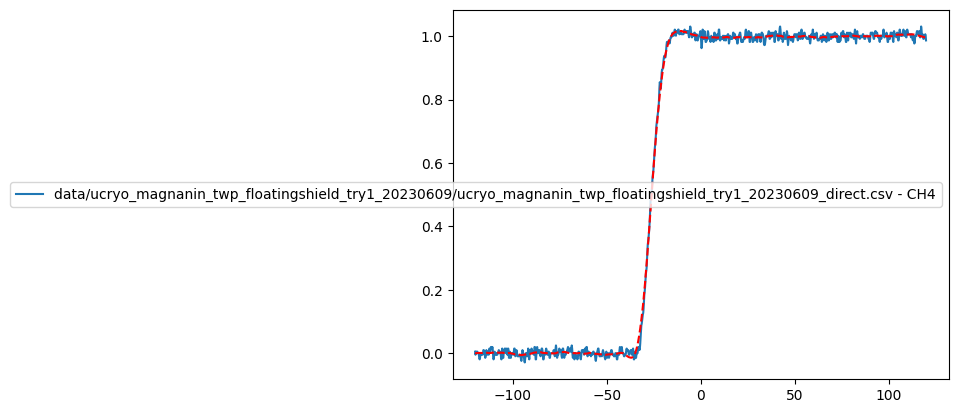

In [6]:
sys.argv[1]='data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_direct.csv'; exec(open('make_pwl_file.py').read())

A filtered version of the measured pulse is saved to the PWL file.  The first column is the time in ns, starting from zero (ignoring offset in data), and the second is in mV.  The columns are comma delimited.  For simplicity, shift vertical level of data so that it starts at zero.

In [7]:
!head -n 5 pwlfiles/ucryo_magnanin_twp_floatingshield_try1_20230609_direct.pwl

0.000n,0.692m
0.200n,0.415m
0.400n,0.322m
0.600n,0.549m
0.800n,0.908m


Copy [ltra_test.asc](ltra_test.asc) to [tdr_4ftucryomanginintwp_floatingshield.asc](tdr_4ftucryomanginintwp_floatingshield.asc).  Starting with this:

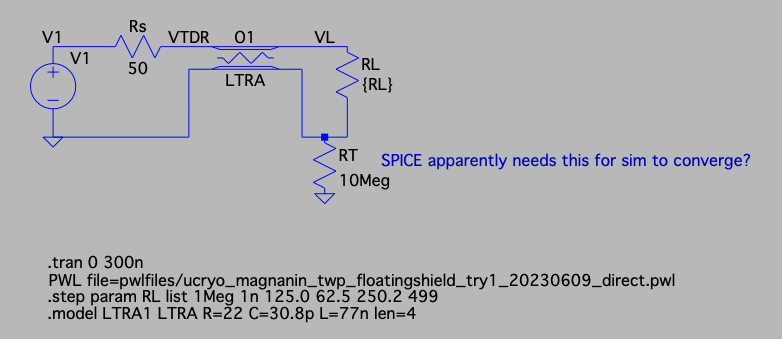

Had to add RT to get simulation to converge.  May need to think about that later, but got the idea from [SPICE_Simulations_Series_SQUID_Array.pdf](SPICE_Simulations_Series_SQUID_Array.pdf).

This will simulate the circuit shown for the listed RLs.

Next, run the simulation and leave the plot open.  We can then use the ltspice python library to plot our TDR measurements versus the simulation like this (can install this module with `pip3 install ltspice`):

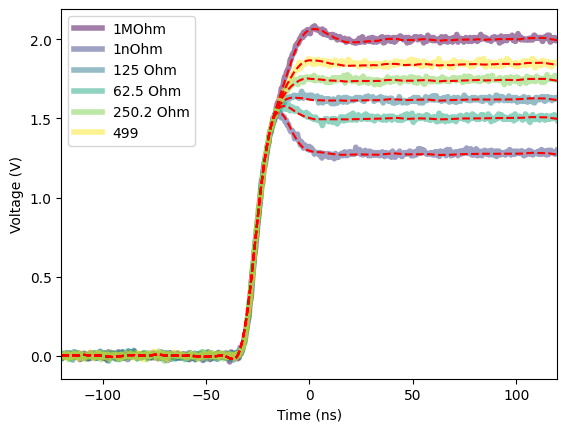

In [41]:
import ltspice

#
# Data
#
datafiles=['data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_open.csv',
           'data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_shorted.csv',
           'data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_125Ohm.csv',
           'data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_62pt5Ohm.csv',
           'data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_250pt2Ohm.csv',
           'data/ucryo_magnanin_twp_floatingshield_try1_20230609/ucryo_magnanin_twp_floatingshield_try1_20230609_499Ohm.csv']

# LTSpice trans data starts at zero, so pull the start time from the first dataset and use to offset the model data.
# assumes datasets were all taken with the same time offset.
datalabels=['1MOhm',"1nOhm","125 Ohm","62.5 Ohm","250.2 Ohm","499"]
mint,maxt=None,None

# Pick a nice color map
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,len(datafiles))))

# Load datasets, and plot.  Also extract time offset for model.
for datalabel,datafile in zip(datalabels,datafiles):
    datadf=pd.read_csv(datafile, index_col=False)
    datadf=datadf.dropna(axis=1,how='all')
    
    t_ns=1.e9*datadf['in s'].values
    v4=datadf['C4 in V'].values
    v4=v4-np.mean(v4[:200]) # shifts starting voltage to zero to simplify plots
    plt.plot(t_ns,v4,label=f'{datalabel}',alpha=0.5,lw=4) # plot with some transparency so can overlay model
    if mint is None:
        mint=np.min(t_ns)
        maxt=np.max(t_ns)

#
# Overplot model.  LTSpice must be open and sim must have been run.
#
ascpath = 'tdr_4ftucryomanginintwp_floatingshield.raw'
l = ltspice.Ltspice(ascpath)
l.parse() # Data loading sequence. It may take few minutes for huge file.

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,len(datafiles))))

for i in range(l.case_count):
    time = l.get_time(i)    
    vtdr = l.get_data('V(vtdr)',i)
    plt.plot(mint+time*1.e9,2.*vtdr,'r--') # 2x here because fcn gen outputs 2x the programmed signal in 50 Ohm mode

plt.xlabel('Time (ns)')
plt.xlim(mint,maxt)
plt.ylabel('Voltage (V)')

plt.legend()    
    
plt.xlabel('Time (ns)')
plt.xlim(mint,maxt)
plt.ylabel('Voltage (V)')

plt.legend()

That's for R = 22 Ohm/ft, C=17 pF/ft, and L=260 nH/ft for 4 ft length.  That would imply a transmission line impedance of sqrt(L/C) ~ 125 Ohm, which is where hand trimming the termination resistor seemed to visually give the least amount of reflection.

Looks good for now, but may want to look at minimizing, and also look at for fixed impedance how the shapes change with L, C, and R.